# How to Train Scaled-YOLOv4 on Custom Objects

[COLAB LINK](https://drive.google.com/file/d/1tS6RkL7OuoAac4d1hir--sstyHNdjje4/view?usp=sharing)

<font color='red'>IMPORTANT! THIS NOTEBOOK WAS RUN ON YANDEX DATASPHERE. IF YOU NEED TO RUN IT IN COLAB PLEASE CHANGE ALL THE DIRECTORIES PATHS!</font>

Based on [this tutorial](https://colab.research.google.com/drive/1LDmg0JRiC2N7_tx8wQoBzTB0jUZhywQr).

Scaled-YOLOv4 uses the same training procedures as YOLOv5.

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Steps
To train this detector we take the following steps:

* Install Scaled-YOLOv4 dependencies
* Download custom Scaled-YOLOv4 object detection data
* Write our Scaled-YOLOv4 Training configuration
* Run Scaled-YOLOv4 training
* Evaluate Scaled-YOLOv4 performance
* Visualize Scaled-YOLOv4 training data
* Run Scaled-YOLOv4 inference on test images

# Install Dependencies


In [ ]:
# clone Scaled_YOLOv4
!git clone https://github.com/roboflow-ai/ScaledYOLOv4.git  # clone repo
%cd /home/jupyter/work/resources/ScaledYOLOv4/
#checkout the yolov4-large branch
!git checkout yolov4-large

Cloning into 'ScaledYOLOv4'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 389.37 KiB | 2.21 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/home/jupyter/work/resources/ScaledYOLOv4
Branch 'yolov4-large' set up to track remote branch 'yolov4-large' from 'origin'.
Switched to a new branch 'yolov4-large'


In [ ]:
#!g1.1
import torch
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.0+cu102 _CudaDeviceProperties(name='Tesla V100-PCIE-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)


In [ ]:
%cd /home/jupyter/work/resources

%pip install -e ./mish-cuda

/home/jupyter/work/resources
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/jupyter/work/resources/mish-cuda
  Running setup.py develop for mish-cuda
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
#!g1.1
#install mish activation funciton for cuda
#%cd /content
%cd /home/jupyter/work/resources/
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!sudo python3 setup.py build install

In [ ]:
%pip install -U PyYAML

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 596 kB 2.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moto 1.3.14 requires idna<2.9,>=2.5, but you have idna 2.10 which is incompatible.
dvc 1.4.0 requires PyYAML<5.4,>=5.1.2, but you have pyyaml 6.0 which is incompatible.
cfn-lint 0.33.2 requires jsonschema~=3.0, but you have jsonschema 4.2.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
%cd /home/jupyter/work/resources/ScaledYOLOv4/

/home/jupyter/work/resources/ScaledYOLOv4


# Custom Dataset 



In [ ]:
%pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1S2fSLc6ftGebwFa2pPH")
project = rf.workspace().project("cv-ass2")
dataset = project.version(4).download("yolov5")

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to cv-ass2-4 in yolov5pytorch:: 100%|██████████| 348/348 [00:00<00:00, 793.98it/s]


In [ ]:
# Export code snippet and paste here
%cd /home/jupyter/work/resources
!#after following the link above, recieve python code with these fields filled in
#from roboflow import Roboflow
#rf = Roboflow(api_key="YOUR API KEY HERE")
#project = rf.workspace().project("YOUR PROJECT")
#dataset = project.version("YOUR VERSION").download("yolov5")

/home/jupyter/work/resources


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/data.yaml

names:
- camera
- smokedet
nc: 2
train: cv-ass2-4/train/images
val: cv-ass2-4/valid/images


#Inspect Model Configuration and Architecture

Let's look at the Scaled-YOLOv4 Configuration architecture

In [ ]:
%cat /home/jupyter/work/resources/ScaledYOLOv4/models/yolov4-csp.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [12,16, 19,36, 40,28]  # P3/8
  - [36,75, 76,55, 72,146]  # P4/16
  - [142,110, 192,243, 459,401]  # P5/32

# yolov4-csp backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, Bottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 9-P5/32
   [-1, 4, BottleneckCSP, [1024]],  # 10
  ]

# yolov4-csp head
# na = len(anchors[0])
head:
  [[-1, 1, SPPCSP, [512]], # 11
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [8, 1, Conv, [256, 1, 1]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   [-1, 2, Bott

# Train Custom Scaled-YOLOv4 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights.
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
!gdown https://drive.google.com/file/d/1TdKvDQb2QpP4EhOIyks8kgT8dgI1iOWT

In [ ]:
#!g1.1
# train scaled-YOLOv4 on custom data for 100 epochs
# time its performance
#%%time
%cd /home/jupyter/work/resources/ScaledYOLOv4/
!python3 train.py --img 416 --batch 16 --epochs 100 --data /home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/data.yaml --cfg ./models/yolov4-csp.yaml --weights 'yolov4-csp.weights' --name yolov4-csp-results  --cache


/home/jupyter/work/resources/ScaledYOLOv4
Using CUDA device0 _CudaDeviceProperties(name='Tesla V100-PCIE-32GB', total_memory=32510MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/yolov4-csp.yaml', data='/home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/data.yaml', device='', epochs=100, evolve=False, global_rank=-1, hyp='data/hyp.finetune.yaml', img_size=[416, 416], local_rank=-1, logdir='runs/', multi_scale=False, name='yolov4-csp-results', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov4-csp.weights', world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate

Exception: Process exited with code 1

In [ ]:
#!g1.1
!python3 train.py --img 416 --batch 16 --epochs 100 --data /home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/data.yaml --cfg ./models/yolov4-csp.yaml --weights '' --resume 'runs/exp3_yolov4-csp-results/weights/last.pt' --name yolov4-csp-results  --cache


Resuming training from runs/exp3_yolov4-csp-results/weights/last.pt
Using CUDA device0 _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', total_memory=32510MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/yolov4-csp.yaml', data='/home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/data.yaml', device='', epochs=100, evolve=False, global_rank=-1, hyp='data/hyp.finetune.yaml', img_size=[416, 416], local_rank=-1, logdir='runs/', multi_scale=False, name='yolov4-csp-results', noautoanchor=False, nosave=False, notest=False, rect=False, resume='runs/exp3_yolov4-csp-results/weights/last.pt', single_cls=False, sync_bn=False, total_batch_size=16, weights='runs/exp3_yolov4-csp-results/weights/last.pt', world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t':

# Evaluate Custom Scaled-YOLOv4 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

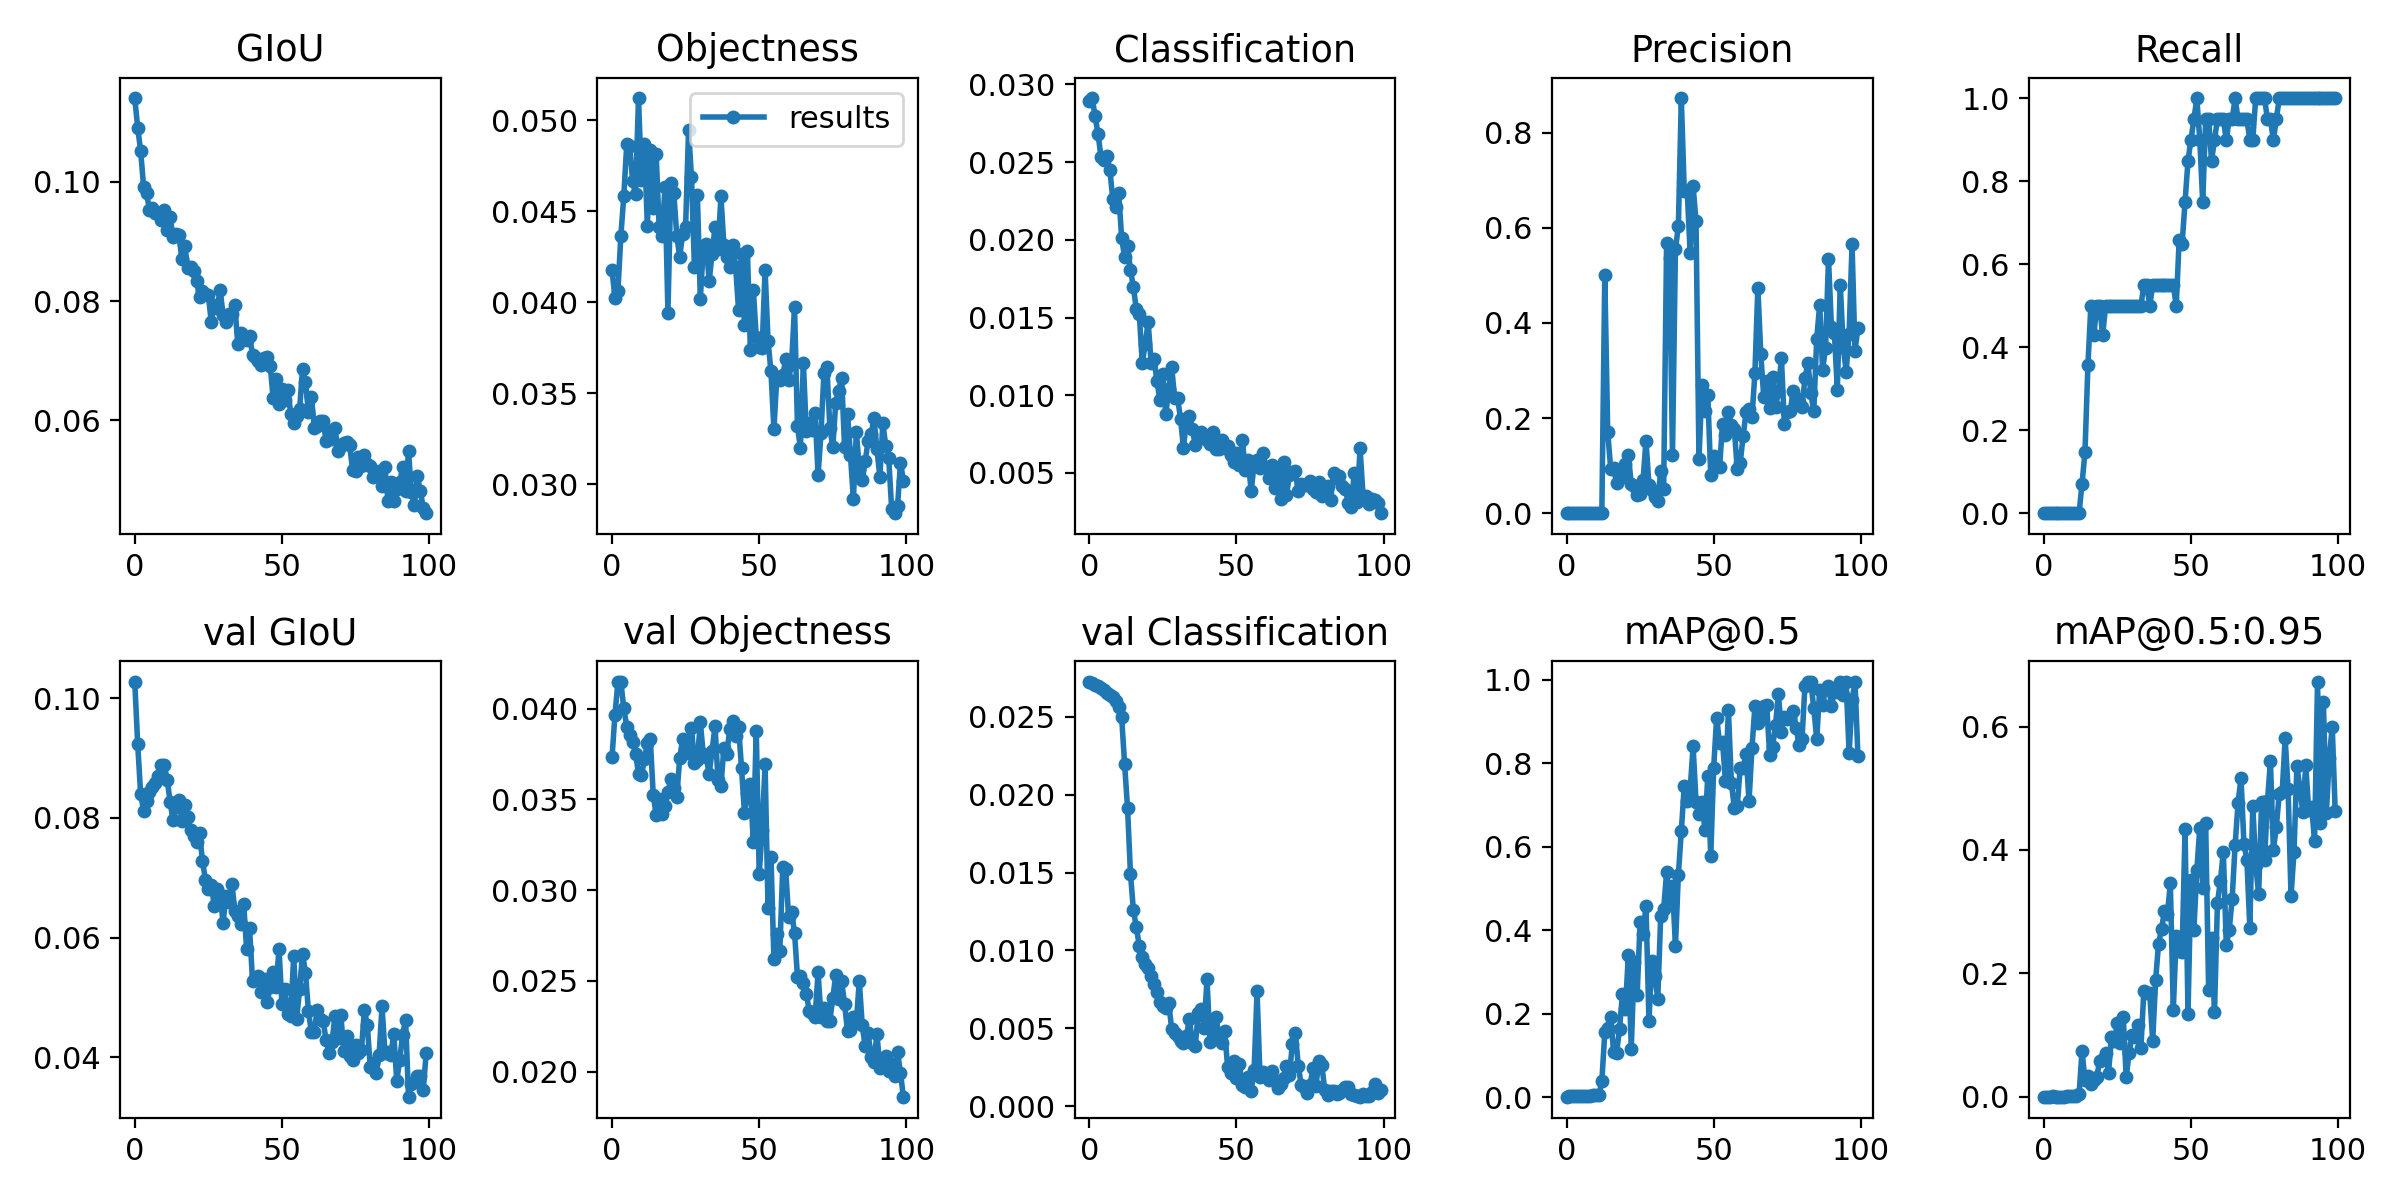

In [ ]:
from IPython.display import Image, display
display(Image('runs/exp4_yolov4-csp-results/results.png'))  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/ScaledYOLOv4/runs/exp0_yolov4-csp-results/test_batch0_gt.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/ScaledYOLOv4/runs/exp0_yolov4-csp-results/train_batch0.jpg', width=900)

# Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
#!g1.1
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
#%cd /content/ScaledYOLOv4/
!python3 detect.py --weights ./runs/exp4_yolov4-csp-results/weights/last_yolov4-csp-results.pt --img 416 --conf 0.4 --iou-thres 0.2 --source cv-ass2-4/valid/images


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.2, output='inference/output', save_txt=False, source='cv-ass2-4/valid/images', update=False, view_img=False, weights=['./runs/exp4_yolov4-csp-results/weights/last_yolov4-csp-results.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', total_memory=32510MB)

Fusing layers... Model Summary: 235 layers, 5.24759e+07 parameters, 5.04494e+07 gradients
image 1/16 /home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/valid/images/IMG20211203223758_jpg.rf.46d37c1ca50f09bc786ddec389a688b8.jpg: 416x416 Done. (0.015s)
image 2/16 /home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/valid/images/IMG20211203224056_jpg.rf.b9d67497d853f70f7d04997736983cc1.jpg: 416x416 1 smokedets, Done. (0.015s)
image 3/16 /home/jupyter/work/resources/ScaledYOLOv4/cv-ass2-4/valid/images/IMG20211203224145_jpg.rf.a244fcc6e17eee27c008a948b719e576.jpg: 416x416 1 smokedets, Done. (0.015s)
image

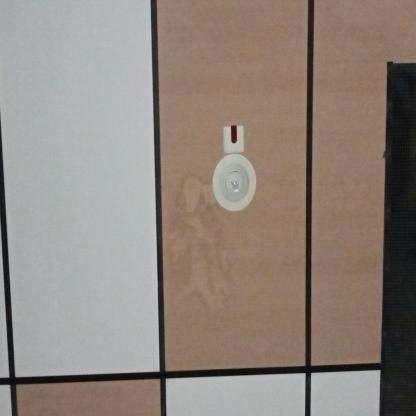

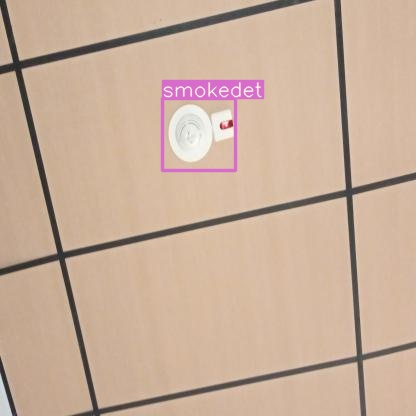

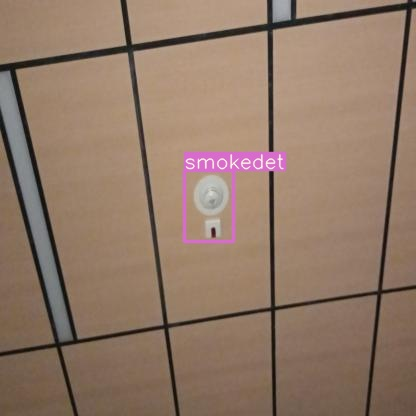

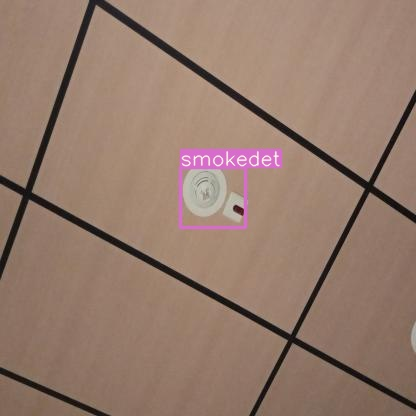

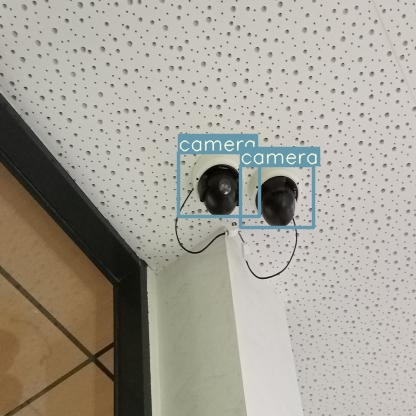

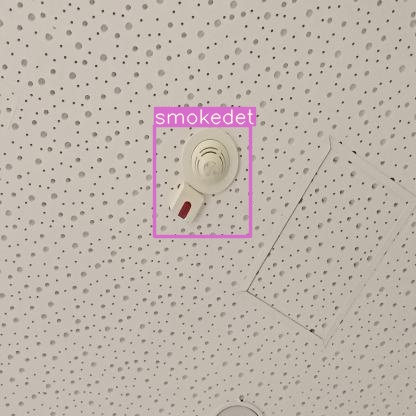

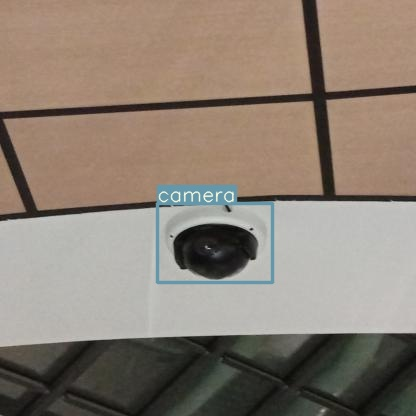

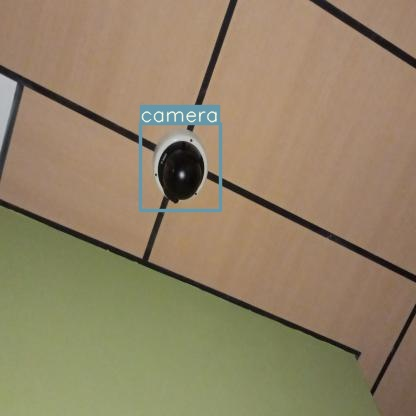

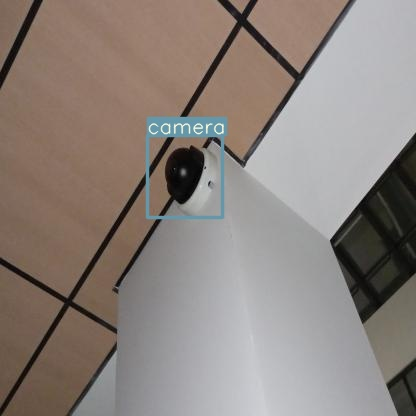

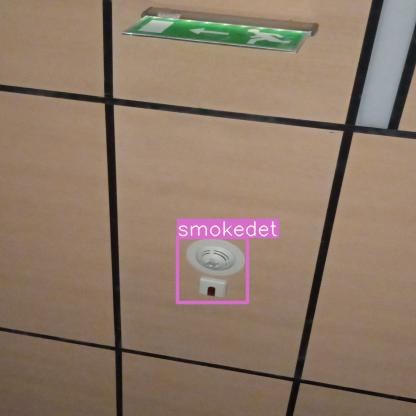

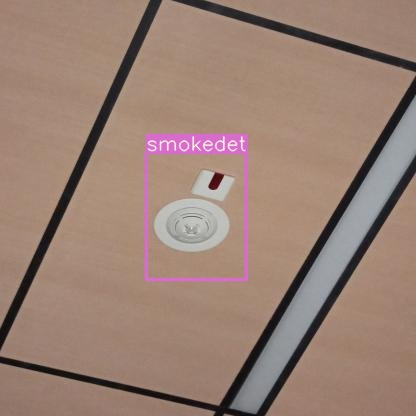

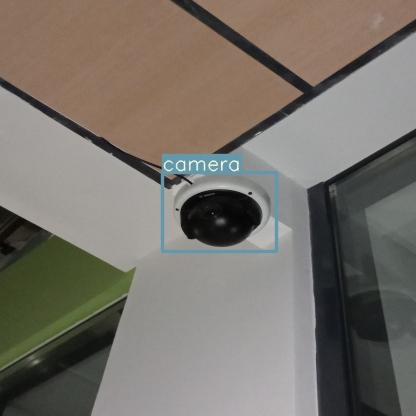

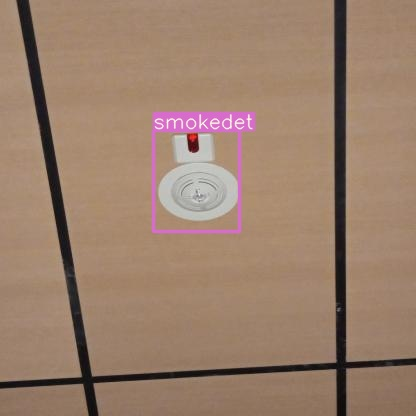

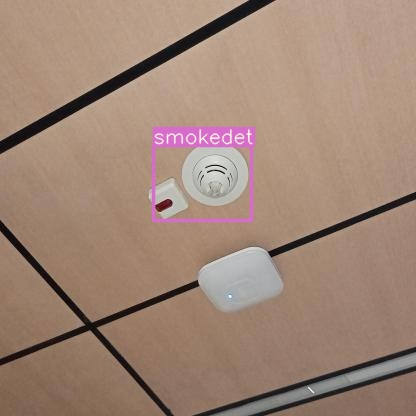

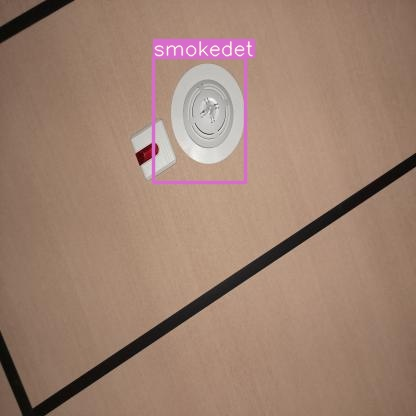

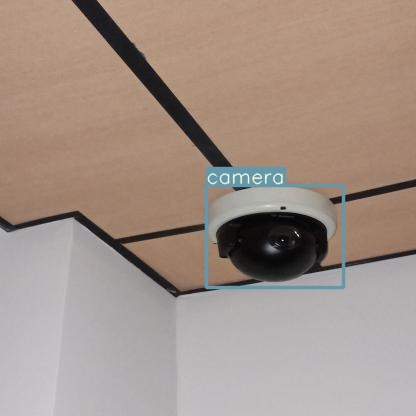

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above
import glob
from IPython.display import Image, display

for imageName in glob.glob('./inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")